# Проектная работа "Основы машинного обучения".

## Задача
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Необходимо:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
   - 1) выделить целевые группы клиентов;
   - 2) предложить меры по снижению оттока;
   - 3) определить другие особенности взаимодействия с клиентами.
   
### Шаг 1. Загрузим данные

Импортируем необходимые для работы библиотеки.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools

Загрузим данные из файла.

In [ ]:
data = pd.read_csv('/datasets/gym_churn.csv')

data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Мы получили таблицу с 13 признаками и 1 целевой переменной.  
  
Признаки:  
`gender` — пол;  
`Near_Location` — проживание или работа рядом с фитнес-центром;  
`Partner` — сотрудник компании-партнёра клуба;  
`Promo_friends` — пришел по акции «приведи друга»;  
`Phone` — наличие контактного телефона;  
`Age` — возраст;  
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);  
`Contract_period` — длительность текущего действующего абонемента;  
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
`Group_visits` — факт посещения групповых занятий;  
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;  
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;  
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра.  
  
Целевой показатель:  
`Churn` — факт оттока в текущем месяце.  

### Шаг 2. Исследовательский анализ данных (EDA)

Проверим наличие пропусков.

In [ ]:
data.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Пропусков данных не обнаружили.

Проверим наличие дубликатов.

In [ ]:
data.duplicated().sum()

0

Дубликатов также не обнаружено.

Изучим средние значения и стандартные отклонения для всех данных.

In [ ]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Изучая данные, мы можем замеить, что:  
- 84% посетителей клуба живут рядом;   
- 48% работники компании партнера клуба;  
- мужчин и женщин в клубе примерно поровну;  
- только 30% пришли по акции "приведи друга";  
- 90% оставили свой телефон;  
- 41% посещает групповые заятия;  
- средний возраст пользователей 29 лет, причем не большое стандартное отклонение равное 3, говорит о том, что разврос в возрасте не велик;  
- лайфтайм пользователя 3,7 месяца, но учитывая большое стандартное отклонение, величина сильно колеблится, что не удивительно;  
- такая же ситуация с количеством месяцев до конца абонимента, в среднем 4,32 месяца, но разброс очень велик;  
- средняя частота посещения в неделю за все время - 1,88 раза;  
- средняя частота посещенияв неделю за последний месяц - 1,77 раз;  
- средняя выручка за иные услуги клуба 147 единиц в месяц, но опять же стандартное отклонение велико - 96, что означает, что кто-то платит в среднем 51, а кто-то 243;
- и самое интересное - доля оттока в текущем месяце 26,5%.  
  
  
Теперь рассмотрим эти же параметры, но с разбивкой по группам. Для тех кто ушел, и тех кто остался.


In [ ]:
pd.set_option('display.max_columns', 500)
data.groupby('Churn').describe()

gender                                              Near_Location  \
        count      mean       std  min  25%  50%  75%  max         count   
Churn                                                                      
0      2939.0  0.510037  0.499984  0.0  0.0  1.0  1.0  1.0        2939.0   
1      1061.0  0.510839  0.500118  0.0  0.0  1.0  1.0  1.0        1061.0   

                                                   Partner            \
           mean       std  min  25%  50%  75%  max   count      mean   
Churn                                                                  
0      0.873086  0.332933  0.0  1.0  1.0  1.0  1.0  2939.0  0.534195   
1      0.768143  0.422217  0.0  1.0  1.0  1.0  1.0  1061.0  0.355325   

                                         Promo_friends                      \
            std  min  25%  50%  75%  max         count      mean       std   
Churn                                                                        
0      0.498914  0.0  0.0  1.0  1.0  1.0        2939.0  0.353522  0.478144   
1      0.478837  0.0  0.0  0.0  1.0  1.0        1061.0  0.183789  0.387495   

                                 Phone                                     \
       min  25%  50%  75%  max   count      mean       std  min  25%  50%   
Churn                                                                       
0      0.0  0.0  0.0  1.0  1.0  2939.0  0.903709  0.295040  0.0  1.0  1.0   
1      0.0  0.0  0.0  0.0  1.0  1061.0  0.902922  0.296204  0.0  1.0  1.0   

                Contract_period                                           \
       75%  max           count      mean       std  min  25%  50%   75%   
Churn                                                                      
0      1.0  1.0          2939.0  5.747193  4.716942  1.0  1.0  6.0  12.0   
1      1.0  1.0          1061.0  1.728558  2.132371  1.0  1.0  1.0   1.0   

            Group_visits                                                  Age  \
        max        count      mean       std  min  25%  50%  75%  max   count   
Churn                                                                           
0      12.0       2939.0  0.464103  0.498795  0.0  0.0  0.0  1.0  1.0  2939.0   
1      12.0       1061.0  0.268615  0.443448  0.0  0.0  0.0  1.0  1.0  1061.0   

                                                          \
            mean       std   min   25%   50%   75%   max   
Churn                                                      
0      29.976523  3.009933  19.0  28.0  30.0  32.0  41.0   
1      26.989632  2.895163  18.0  25.0  27.0  29.0  38.0   

      Avg_additional_charges_total                                   \
                             count        mean        std       min   
Churn                                                                 
0                           2939.0  158.445715  99.801599  0.171862   
1                           1061.0  115.082899  77.696419  0.148205   

                                                    Month_to_end_contract  \
             25%         50%         75%        max                 count   
Churn                                                                       
0      76.920993  149.881171  224.448274  552.59074                2939.0   
1      50.629127  103.814686  165.616858  425.53522                1061.0   

                                                     Lifetime            \
           mean       std  min  25%  50%   75%   max    count      mean   
Churn                                                                     
0      5.283089  4.363522  1.0  1.0  6.0  10.0  12.0   2939.0  4.711807   
1      1.662582  1.964593  1.0  1.0  1.0   1.0  12.0   1061.0  0.990575   

                                          Avg_class_frequency_total            \
            std  min  25%  50%  75%   max                     count      mean   
Churn                                                                           
0      3.874780  0.0  2.0  4.0  6.0  31

Для тех кто ушел, ситуация такая:  
- мужчин и женщин поровну;  
- 76% проживали рядом с клубом;  
- 35% работали в компании-партнере клуба;  
- 18% пришли по акции "приведи друга";  
- 90% указали свой номер телефона;  
- 26% посещали групповые занятия;  
- в среднем людям из этой группы 27 лет;  
- лайфтайм 0,99 месяца со стандартным отклонением в 1, то есть новички;  
- длительность текущего абонимента в среднем 1,73, а стандартное отклонение аж 2,13;
- с месяцами до окончания абонимента аналогичная ситуация - среднее 1,66, а откнонение 1,96;  
- среднее количество посещений за все время 1,47;  
- среднее количество посещений в неделю за последний месяц 1,04, то есть стали ходить меньше;  
- средняя выручка за иные услуги клуба 115 единиц.

Для тех кто остался ситуация такая:  
- мужчин и женщин поровну;  
- 87% проживали рядом с клубом - побольше чем в группе ушедших, но не критично;  
- 53% работали в компании-партнере клуба - а вот это уже интереснее 35 против 53;  
- 35% пришли по акции "приведи друга" - тут тоже интересно 18 против 35;  
- 90% указали свой номер телефона;  
- 46% посещали групповые занятия - а из тех кто уше посещали занятия только 26%;  
- в среднем людям из этой группы 30 лет - оставшиеся явно постарше;  
- лайфтайм 4,71 месяца со стандартным отклонением в 4,9, то есть остаются и те, кто с нами давно, и те, кто пришел недавно;  
- длительность текущего абонимента в среднем 5,7, если сравнить с ушедшими, то там всего 1,73;
- с месяцами до окончания абонимента аналогичная ситуация - среднее 5,28, а у ушедших 1,66;  
- среднее количество посещений за все время 2,02;  
- среднее количество посещений в неделю за последний месяц 2,02, то есть меньше ходить в последний месяц не стали;  
- средняя выручка за иные услуги клуба 158 единиц, что немного больше чем у ушедших.  
  
Теперь посмтроим для этих групп столбчатые гистограммы и распределения признаков, чтобы увидеть все наглядно.  

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

Аналитика просто отличная. Очень хорошо, что так подробно описываешь данные!
</div>

gender


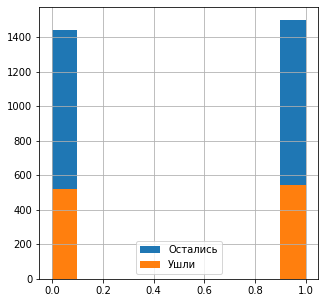

Near_Location


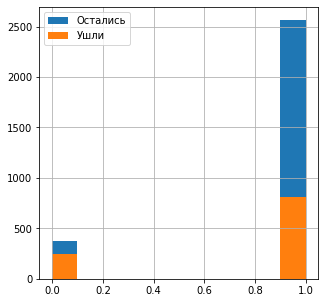

Partner


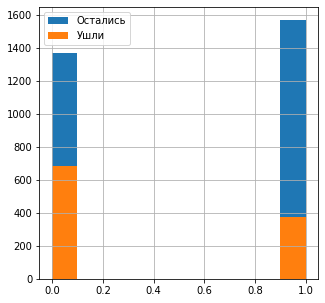

Promo_friends


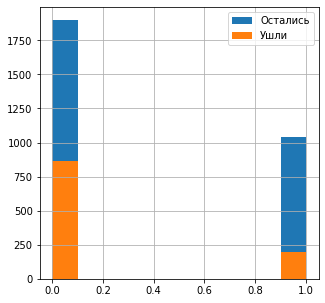

Phone


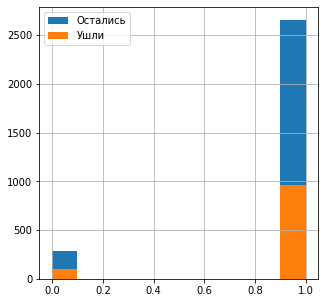

Contract_period


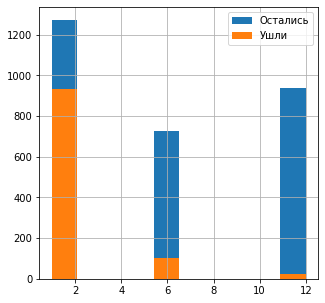

Group_visits


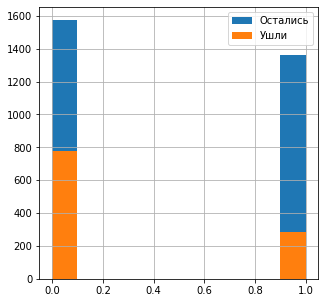

Age


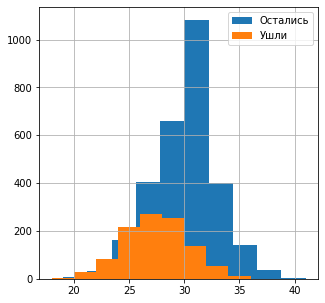

Avg_additional_charges_total


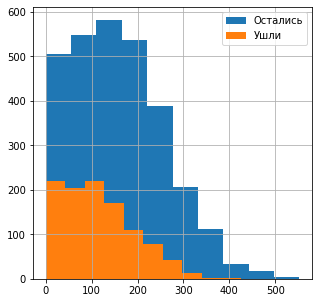

Month_to_end_contract


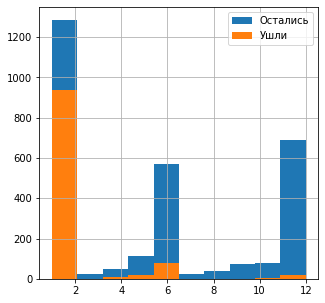

Lifetime


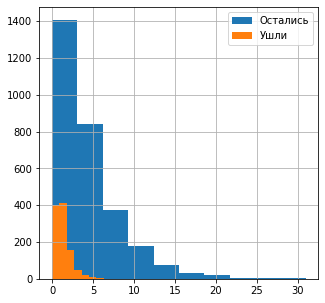

Avg_class_frequency_total


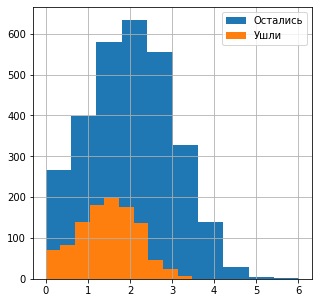

Avg_class_frequency_current_month


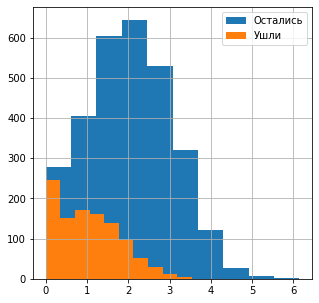

Churn


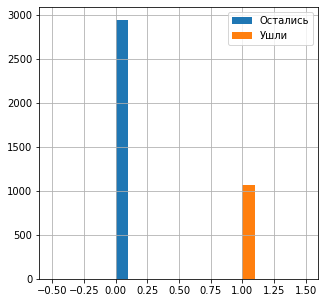

In [ ]:
for col in data.columns:

    print(col)

    data.query('Churn == 0')[col].hist()
    
    data.query('Churn == 1')[col].hist(figsize=(5,5))
    plt.legend(labels=['Остались', 'Ушли'])
    plt.show()

Исходя из полученных данных можем попробовать собрать портрет пользователя, который наиболее вероятно покинет клуб.  
Покидающий клуб пользователь:  
- работает не в компании партнере,  
- пришел не по акции "приведи друга",  
- имеет абонимент на 1 месяц,  
- не посещает групповых занятий,  
- имеет возраст примерно 27 лет,  
- пришел в клуб менее 2х месяцев назад,  
- за последний месяц стал посещать клуб меньше раз в неделю, чем за весь предыдущий период.   
  
Также мы заметили, что некоторые величины плотно связаны друг с другом, например, на какое количество месяцев взят абонимент и сколько месяцев осталось до его конца. И это логично.  
Отобразим матрицу корреляции между признаками, чтобы наглядно увидеть все взяимосвязи.  

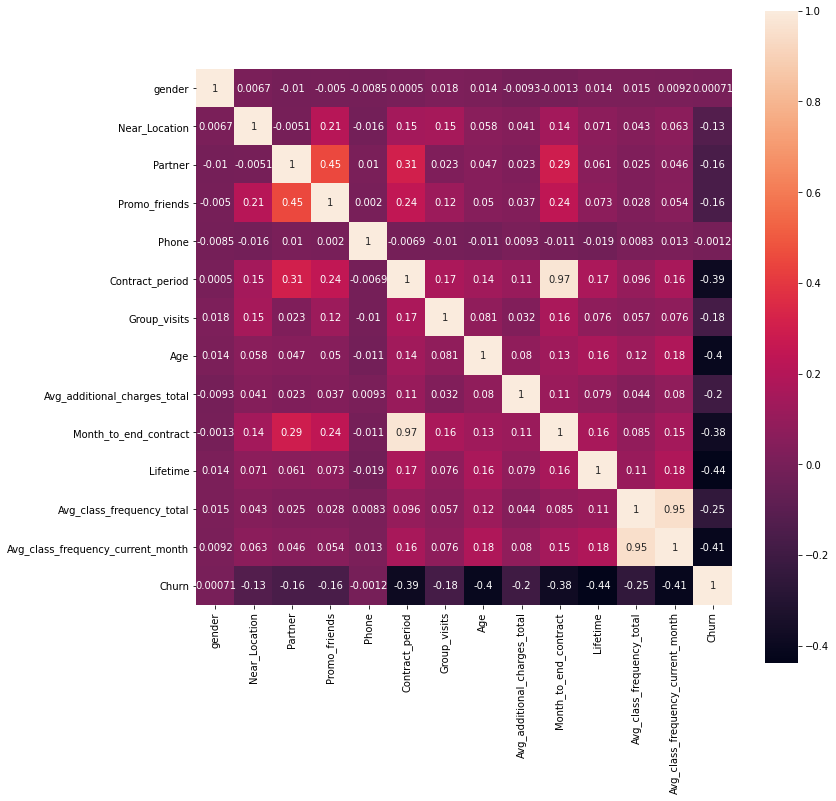

In [ ]:

cm = data.corr() 
fig, ax = plt.subplots()

sns.heatmap(cm, annot=True, square=True)


fig.set_figheight(12) 
fig.set_figwidth(12)
plt.show()

Как и ожиладалось, связь сильная обнаружилась между признаками:  
- "длительность текущего действующего абонемента" и "срок до окончания текущего действующего абонемент";  
- "средняя частота посещений в неделю за предыдущий месяц" и "средняя частота посещений в неделю за все время с начала действия абонемента".  
  
Так же стоит обратить внимание на параметры:  
- "сотрудник компании-партнёра клуба" и "приход по акции «приведи друга»".  
Скорее всего сотрудники приходят сами и приглашают друзей.  

А так же:
- "сотрудник компании-партнёра клуба" и "длительность текущего действующего абонемента",  
- "сотрудник компании-партнёра клуба" и "срок до окончания текущего действующего абонемента",  
- "приход по акции «приведи друга»" и "длительность текущего действующего абонемента",  
- "приход по акции «приведи друга»" и "срок до окончания текущего действующего абонемента".  
На длительность абонимента явно хорошо влияет то, работает ли клиент в компании партнере/пришел по акции "приведи друга".  


#### Вывод.
На этом этапе мы изучили данные, обнаружили некоторые закономерности, теперь применим машинное обучение.


### Шаг 3. Построим модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Разберем данные на обучающую и валидационную выборку функцией `train_test_split()`.

In [ ]:
X = data.drop('Churn', axis = 1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель на train-выборке двумя способами:
- логистической регрессией - `lg_model`,
- случайным лесом - `rf_model`.

In [ ]:
lg_model = LogisticRegression(solver='liblinear') 
lg_model.fit(X_train, y_train)
lg_predictions = lg_model.predict(X_test)
lg_probabilities = lg_model.predict_proba(X_test)[:, 1]



rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

print('Доля оттока')
print('Модель логистической регрессии', '{:0.1%}'.format(lg_predictions.mean()))
print('Модель случайного леса', '{:0.1%}'.format(rf_predictions.mean()))



Доля оттока
Модель логистической регрессии 23.9%
Модель случайного леса 24.1%


Значения похожи на правду, за текущий месяц отток был 26,5%. Модели сработали не плохо, хорошо бы сравнить, какая справиласьь лучше?

Для этого оценим метрики `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке. 

In [ ]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
   

print_all_metrics(
    y_test,
    lg_predictions,
    lg_probabilities, 
    title='Метрики для модели логистической регрессии:'
)


print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)


Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


Сравним модели:  
Разница в метриках не велика, но модель логистической регресии в данном случае показала результаты чуть лучше.

### Шаг 4. Выполним кластеризацию клиентов.

Для начала стандартизируем данные:

In [ ]:
scaler = StandardScaler()
scaler.fit(X)

Xs_st =scaler.transform(X) 

Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисуем дендрограмму.

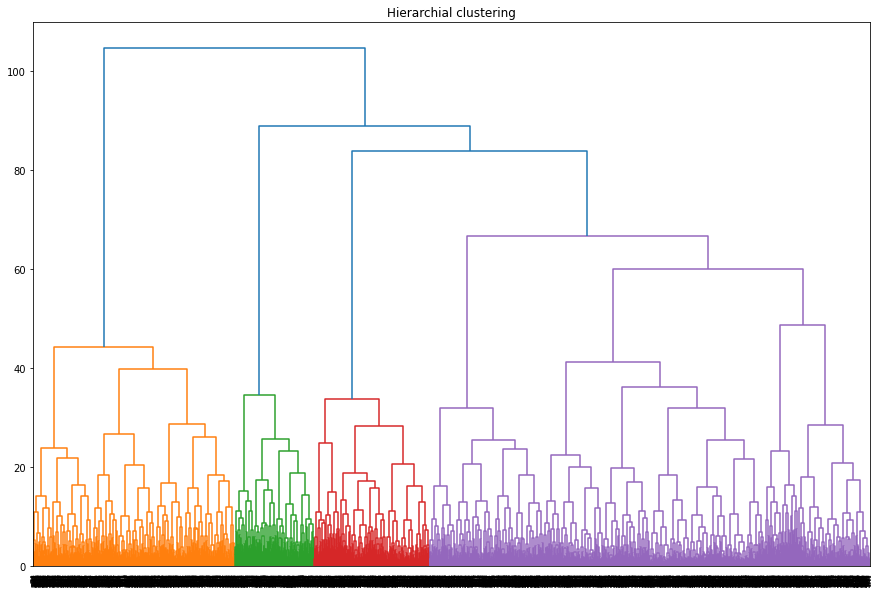

In [ ]:
linked = linkage(Xs_st, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show()

Согласно дендрограмме предположительное оптимальное количество кластеров - 4, так как на дендрограмме 4 цвета. Фиолетовый кластер самый многочисленный, а зеленый напротив самый малочисленный.

Обучим модель кластеризации на основании алгоритма K-Means.  
По заданию предложено взять количество кластеров равное 5 для того, чтобы результаты не отличались.

In [ ]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(Xs_st)

data['cluster_km'] = labels

Рассмотрим на средние значения признаков для кластеров.

In [ ]:
data.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Что можно заметить?  
- мужчин и женщин во всех кластерах примерно равное количество;  
- в кластере 2 нет клиентов проживающих рядом с клубом, зато в остальных кластерах таких достаточно высокий процент, в 3, например, абсолютно все;  
- в 0 кластере самый большой процент клиентов из компаний партнеров;  
- в кластере 2 очень мало клиентов пришедших по акции "приведи друга";  
- в кластер 1 попали практически все пользователи не оставившие свой телефон;  
- возраст между кластерами распределен примерно равномерно;  
- в кластер 0 попали клиенты с самыми длинными абониментами, средний срок тут 10,8 месяца;  
- аналогично и для параметра "срок до окончания текущего действующего абонемента" - в 0 кластере самый большой показатель;  
- параментры "Contract_period", "Lifetime", "Avg_additional_charges_total" не имеют каких-то ярких черт;
- а вот по количеству раз посещения клуба в неделю можно отметить, что клиенты из кластера 4 ходят чаще других - почти 3 раза в неделю. Также стоит замерить что для 1, 2 и 3 кластеров посещение за последний месяц несколько сократилось;  
- и самое главное - факт оттока - больше всего клиентов ушло из 2 и 3 кластеров, зато 0 и 4 остались в клубе практически полностью.    

Из увиденного можно сделать вывод, что если клиент не работает в компании партнере или не пришел по акции "приведи друга", состоит в клубе менее 2 месяцев и срок его текущего абонимента не более 2 месяцев, а также за последний месяц он стал реже посещать зал, то скорее всего, он с большой долей вероятности попадет в отток.  
  
  
Построим распределения признаков для кластеров.

gender


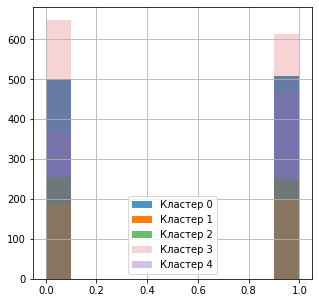

Near_Location


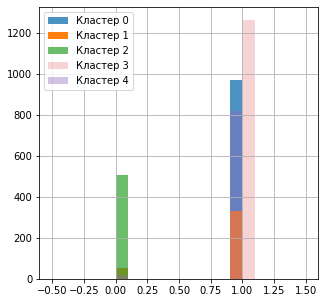

Partner


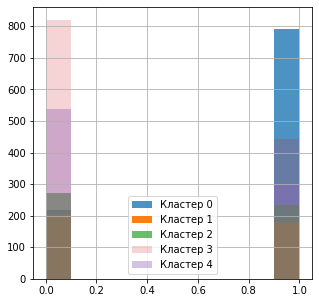

Promo_friends


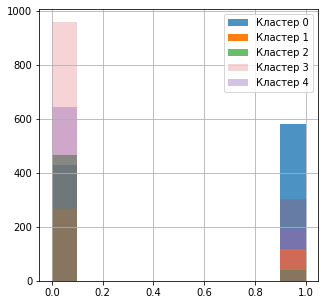

Phone


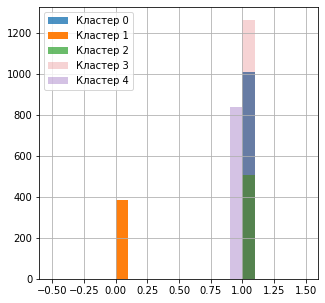

Contract_period


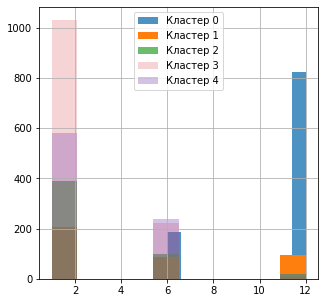

Group_visits


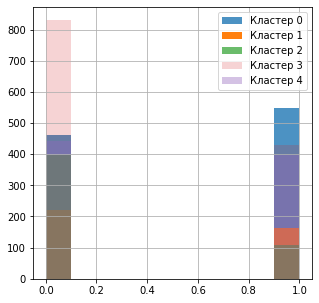

Age


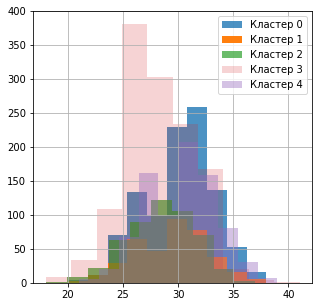

Avg_additional_charges_total


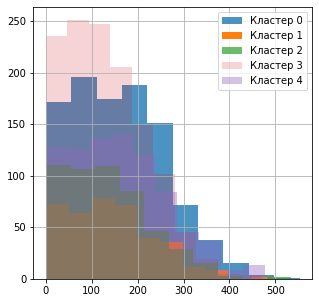

Month_to_end_contract


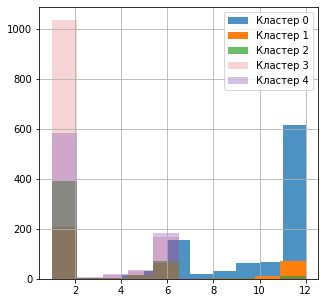

Lifetime


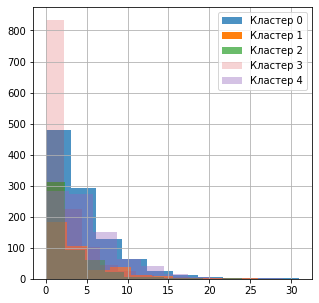

Avg_class_frequency_total


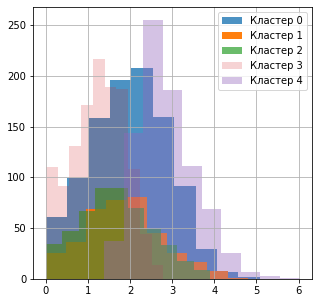

Avg_class_frequency_current_month


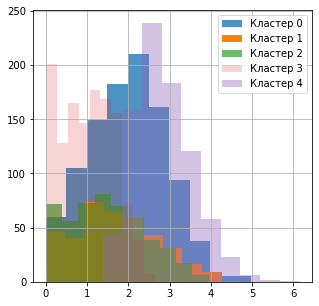

Churn


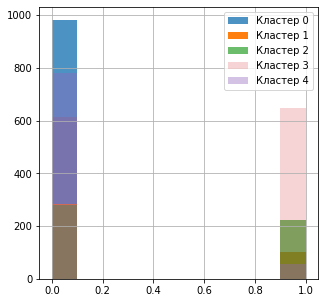

cluster_km


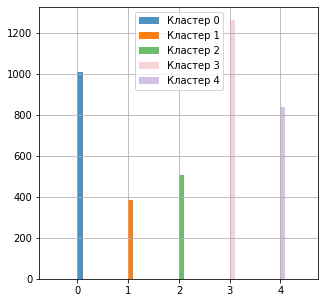

In [ ]:
for col in data.columns:

    print(col)

    data.query('cluster_km == 0')[col].hist(alpha = 0.8)
    data.query('cluster_km == 1')[col].hist(alpha = 1)
    
    data.query('cluster_km == 2')[col].hist(alpha = 0.7)
    data.query('cluster_km == 3')[col].hist(alpha = 0.2)
    data.query('cluster_km == 4')[col].hist(figsize=(5,5), alpha = 0.4)
    plt.legend(labels=['Кластер 0', 'Кластер 1', 'Кластер 2', 'Кластер 3', 'Кластер 4'])
    plt.show()

Из графиков распределений, мы можем сделать выжные дополнения, к уже сказанным выводам:  
- в 3 кластере было больше всего людей, не имеющих отношения к компаниям партнеров и акции "приведи друга";  
- также 3 кластер содержит в себе самое большое количество новичков, тех чей лайфтайм 1 месяц и меньше;  
- длительность абонимента клиентов 3 кластера в основном 1 месяц;  
- распределение возраста клиентов из третьего кластера сдвинуто влево, то есть они младше остальных;  
- и за последний месяц клиенты 3 кластера заметно меньше остальных посещали клуб;  
- кластер 2 не сильно выделяется на фоне остальных, за исключением того, что все клтиенты этого кластера ни проживают, ни работают в районе, где находится клуб.  

Теперь для каждого кластера наглядно посчитаем долю оттока:

In [ ]:
data.groupby('cluster_km')['Churn'].mean().apply(lambda x: '{:0.1%}'.format(x))

cluster_km
0     2.8%
1    26.8%
2    44.4%
3    51.4%
4     6.8%
Name: Churn, dtype: object

Из выше сделанных выводов нет ничего удивительного, что клиенты кластера 3 показали самы большой отток - 51%.  
Клиенты из кластера 2 тоже показали не мало - 44%, но здесь, я думал, нужно сделать вывод о том, что клиентам тяжело ездить в другой район на занятия.  
Самыми надежными оказались кластеры 0 и 4, у них самый низкий показатель оттока.

### Шаг 5. Выводы и рекомендации.  
  
Мы изучили данные сети фитнес-центров «Культурист-датасаентист».  
- Спрогнозировать вероятность оттока для каждого клиента при помощи моделей логистической регрессиии и случайного леса. Выяснили, что в данном конкретном случае модель логистической регрессиии справляется лучше.  
- Сформировать типичные портреты клиентов клуба.
- Проанализировать основные признаки, наиболее сильно влияющие на отток.

И из всего этого, можем выделить, что для сокращения оттока следует обратить внимание на группу клиентов с признаками:  
- Не сотрудник компании-партнёра клуба,  
- Не по акции «приведи друга»,  
- Новичок, пришел в клуб менее 2 месяцев назад,   
- Длительность текущего абонимента 1 месяц,  
- В последний месяц ходит в клуб реже, чем ранее.

Так как эта группа в целом моложе остальных, возможно для удержания стоит обратиться к модным течениям, фишкам, гаджетам. Электронным абониментам, фирменным трекерам для отслеживания тренеровок именно в этом клубе и тому подобное.  Вкусный кофе, молодежная музыка и или скидки для студентов, тоже могут помочь оставить таких клиентов.  

Так же нужно отметить, что значительную долю оттока занимали клитенты не работающие и не проживающие данном районе. Тут можно либо расширить сеть клубов, для того, чтобы каждый мог заниматься в клубе не далеко от дома или работы. Либо так же ввести дополнительные "плюшки" для тех, кто тратит время на долгую дорогу до клуба.  


